In [6]:
%matplotlib widget 

import scipy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from itertools import combinations
# from multiprocessing import Pool
from itertools import starmap
import time
import functools
from scipy.interpolate import CloughTocher2DInterpolator

############################
# Setup global variables:  #
############################
n = 5
symbols = sp.symbols('a_:'+str(n))
matrix = sp.zeros(n,n)

for j in range(n):
    for k in range(n):
        matrix[j,k] = symbols[(j-k)%n]
matrix_constraints = tuple(
    #{'type': 'eq', 'fun': sp.lambdify([matrix[:]], 1-sum(matrix.row(k)), 'numpy')} for k in range (0,n)
)

def sum_kth_principal_minors(matrix, k):
    """Compute the sum of the k-th principal minors of a given matrix."""
    principal_minor_sum = 0
    
    # Get all combinations of row indices for k x k principal minors
    for indices in combinations(range(n), k):
        minor = matrix[indices, indices]  # Extract the k x k principal minor
        principal_minor_sum += minor.det()  # Add the determinant of the minor
    
    return principal_minor_sum

def run_function_with_constraints(loc, constraints = matrix_constraints):
    """Given a function and some constraint functions attempt to minimize the function"""
    bounds = [(0.0, 1.0)] * n**2
    num_starts = 5
    results = []
    
    for _ in range(num_starts):
        initial_guess = np.random.rand(n**2)
        #result = minimize(funcs_of_principal_minors[loc], initial_guess, bounds=bounds, constraints=constraints, method='trust-constr')
        result = minimize(funcs_of_principal_minors[loc], initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')
        results.append(result)
    
    return min(results, key=lambda x: x.fun)

def run_function_with_constraints_and_equal(val, loc, func_num):
    constraints_and_func_1 = matrix_constraints + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc](x) - val)},)
    return run_function_with_constraints(func_num, constraints_and_func_1)

def run_function_with_constraints_and_double_equal(val_1, val_2, loc_1, loc_2, func_num):
    constraints_and_func_2 = matrix_constraints + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc_1](x) - val_1)},) + ({'type': 'eq', 'fun': lambda x : (funcs_of_principal_minors[loc_2](x) - val_2)},)
    return run_function_with_constraints(func_num, constraints_and_func_2)

funcs_of_principal_minors = tuple(
    sp.lambdify([matrix[:]], sum_kth_principal_minors(matrix, k), 'numpy')
    for k in range(1, n+1)
) + tuple(
    sp.lambdify([matrix[:]], -1*sum_kth_principal_minors(matrix, k), 'numpy')
    for k in range(1, n+1)
)

In [8]:
func_to_run = 0
result_min = run_function_with_constraints(func_to_run)
result_max = run_function_with_constraints(func_to_run+n)

np.set_printoptions(precision=3)

print("Minimum value found:", result_min.fun)
print("Achieved at:", result_min.x)
print("Maximum value found:", -1*result_max.fun)
print("Achieved at:", result_max.x)

Minimum value found: 0.0
Achieved at: [0.823 0.459 0.08  0.577 0.847 0.41  0.741 0.515 0.908 0.092 0.034 0.394
 0.786 0.152 0.926 0.399 0.013 0.953 0.794 0.77  0.308 0.939 0.536 0.51
 0.   ]
Maximum value found: 5.0
Achieved at: [0.794 0.652 0.226 0.018 0.428 0.314 0.684 0.216 0.143 0.819 0.151 0.374
 0.96  0.372 0.634 0.669 0.067 0.597 0.673 0.349 0.769 0.057 0.157 0.116
 1.   ]


In [ ]:
result_min = run_function_with_constraints_and_double_equal(val_1=3/2, val_2=1/4, loc_1=0, loc_2=1, func_num=2)
result_max = run_function_with_constraints_and_double_equal(val_1=3/2, val_2=1/4, loc_1=0, loc_2=1, func_num=2+n)

np.set_printoptions(precision=3)

print("Minimum value found:", result_min.fun)
print("Achieved at:", result_min.x)
print("Message:", result_min.message)
print("Maximum value found:", -1*result_max.fun)
print("Achieved at:", result_max.x)
print("Message:", result_max.message)

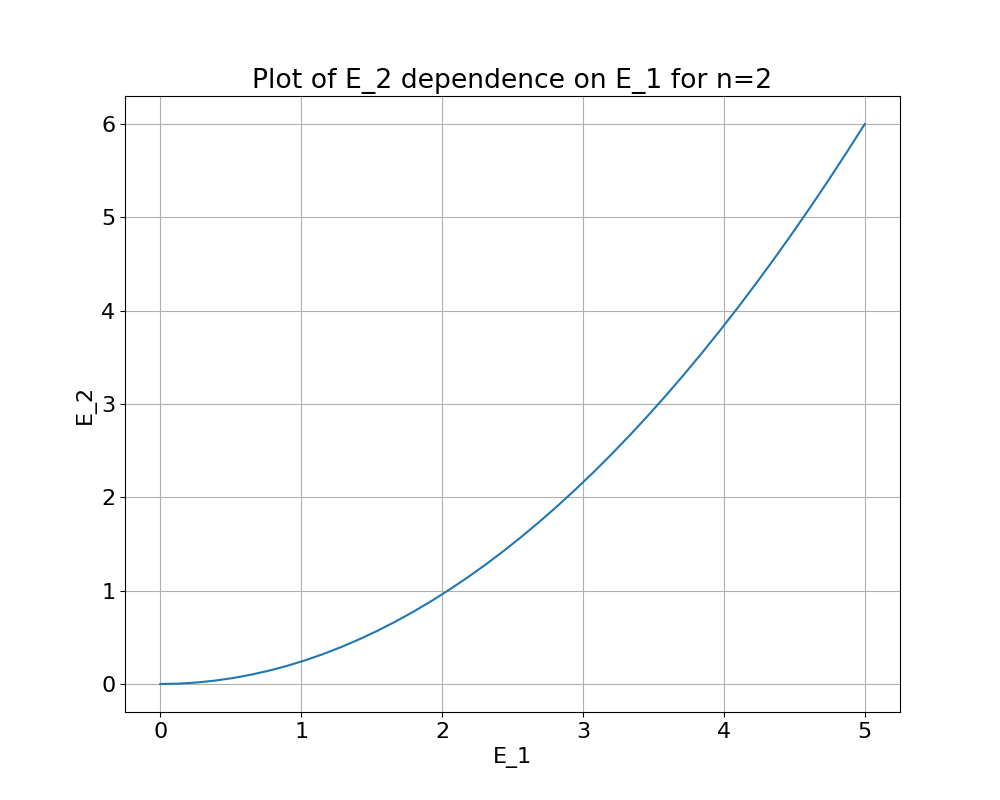

In [7]:
# Generate x values from 0 to 3
x_values = np.linspace(0, n, 40)

min_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1, loc=0), x_values))

min_y_values = [y.fun for y in min_y]

font = {'size': 16}
plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plt.plot(x_values, max_y_values, label='Max', color='C0')
#plt.plot(x_values, min_y_values, label='Min', color='C2')
#plt.axis([0, 7,-3, 15])

plt.title('Plot of E_2 dependence on E_1 for n=2')
plt.xlabel('E_1')
plt.ylabel('E_2')
plt.grid(True)
plt.savefig('niep_2_s1_s2.png', bbox_inches='tight')

In [11]:
def func_z(x, y):
    return run_function_with_constraints_and_double_equal(func_num=2, loc_1=0, val_1=x, loc_2=1, val_2=y).fun


# Generate data points
x_values = np.linspace(0, n, 50)

min_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1, loc=0), x_values))
max_y = list(map(functools.partial(run_function_with_constraints_and_equal, func_num=1+n, loc=0), x_values))

min_y_values = [y.fun for y in min_y]
max_y_values = [y.fun*-1 for y in max_y]

# Create lists to store meshgrid points
X_mesh = []
Y_mesh = []

# Generate meshgrid points
i=0
for xi in x_values:
    y_vals = np.linspace(min_y_values[i], max_y_values[i], 50)
    i = i+1
    X_mesh.append(np.full_like(y_vals, xi))
    Y_mesh.append(y_vals)

X = np.concatenate(X_mesh)
Y = np.concatenate(Y_mesh)

print("XY Done")

#Z_flip = list(pool.starmap(func_z_flipped, zip(X,Y)))
#print("Z 1 Done")
Z = list(starmap(func_z, zip(X,Y)))
print("Z Done")

XY Done
Z Done


Text(0.5, 0, 'Z axis')

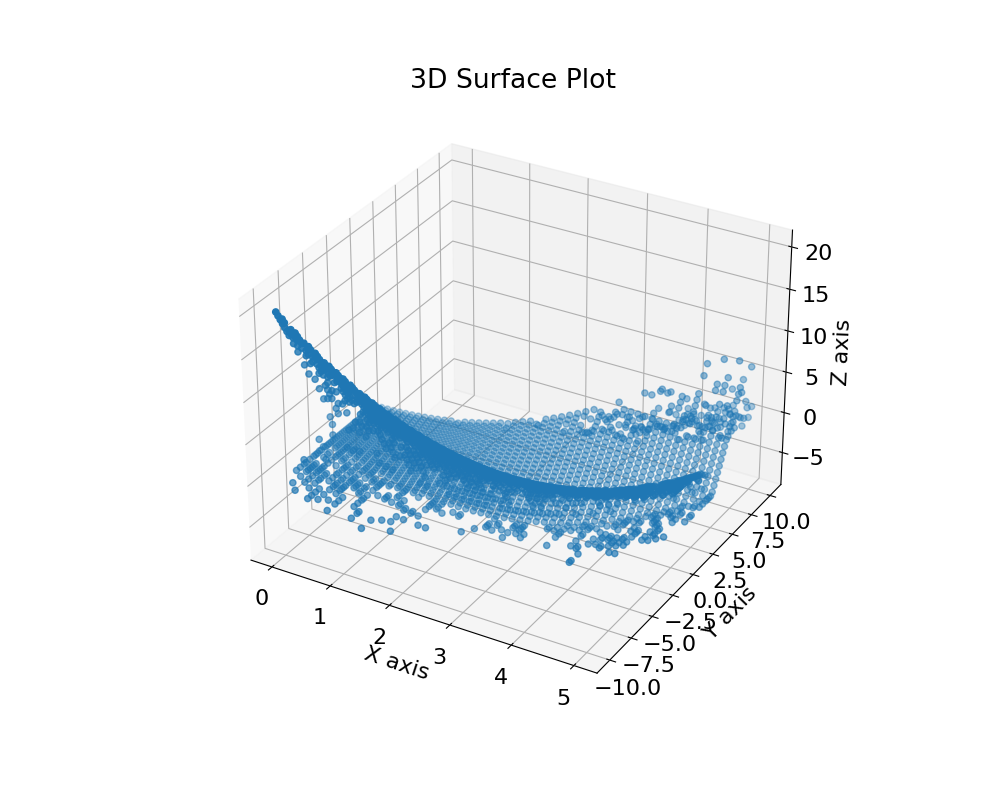

In [12]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
out_plot = ax.scatter(X, Y, Z, color='C0')

# Customize labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')